# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import pitszi
import minot
from minot.ClusterTools import cluster_profile

from pitszi import physics_main as phys

import macsj0717_libs as libs

# Parameters

In [2]:
base = '/Users/adam/Project/Notes-Papier-Conf/2024_07_PITSZI_MACSJ0717/outputs/'

In [3]:
cl_redshift = 0.546
cl_M500     = 18.1*1e14*u.Msun

Tgas = 15*u.keV
cs = phys.sound_speed(Tgas)
print(cs)

1981.3508758974326 km / s


In [4]:
pars1 = np.load(base+'Pk_constraint_RM1_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', allow_pickle=True)
pars2 = np.load(base+'Pk_constraint_RM2_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', allow_pickle=True)
pars3 = np.load(base+'Pk_constraint_RM3_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', allow_pickle=True)
pars4 = np.load(base+'Pk_constraint_RM4_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', allow_pickle=True)
pars5 = np.load(base+'Pk_constraint_RM5_XspecFalse_cleankszFalse_psmaskFalse_appradmodTrue_maskangle2.0/CurveFit_Fluctuation_results.npy', allow_pickle=True)

plist1, popt1, pcov1 = pars1[0], pars1[1], pars1[2].reshape(4,4)
plist2, popt2, pcov2 = pars2[0], pars2[1], pars2[2].reshape(4,4)
plist3, popt3, pcov3 = pars3[0], pars3[1], pars3[2].reshape(4,4)
plist4, popt4, pcov4 = pars4[0], pars4[1], pars4[2].reshape(4,4)
plist5, popt5, pcov5 = pars5[0], pars5[1], pars5[2].reshape(4,4)

# Analysis

[ 4.90402506e-03  5.49708472e+02  2.53248700e+00  4.08262407e+02
 -7.98488018e+00  6.44711776e-01]


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/cluster_profile.py:82: RuntimeWarning: invalid value encountered in power
  term2 = (r3d_kpc / r_c)**(-alpha/2.0)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/cluster_profile.py:83: RuntimeWarning: invalid value encountered in power
  term3 = (1 + (r3d_kpc / r_s)**gamma)**(-epsilon/2.0/gamma)


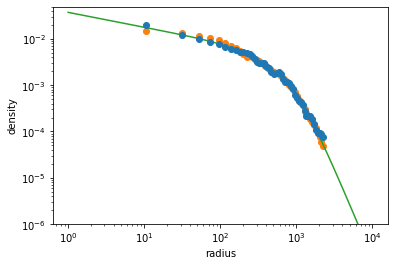

In [5]:
#===== X-ray density profile data
# Get the data
hdul = fits.open('/Users/adam/Project/Notes-Papier-Conf/2015_10_MACSJ0717_Paper/IDL/Save/Xray/densprof_macsj0717.fits')
dat = hdul[1].data
wok = dat['R'] > 0

# SVM fit
def fitfunc(r3d, n0, rc, beta, rs, epsilon, alpha):
    return cluster_profile.svm_model(r3d, n0, rc, beta, rs, 3, epsilon, alpha)

pars, parscov = curve_fit(fitfunc, dat['R'][wok], dat['DENS'][wok], 
                          sigma=dat['ERRMDENS'][wok], absolute_sigma=True)
print(pars)

# Check the correct interpolation
plt.errorbar(dat['R'], dat['DENS'], dat['ERRMDENS'], marker='o', ls='')
plt.plot(dat['R'], savgol_filter(dat['DENS'], 21,2), marker='o', ls='')
plt.plot(np.logspace(0,4,100), fitfunc(np.logspace(0,4,100), *pars))
plt.xscale('log')
plt.yscale('log')
plt.ylabel('density')
plt.xlabel('radius')
plt.ylim(1e-6,5e-2)

# Xray model
rad_x = np.logspace(0,4,1000)*u.kpc
n_x = fitfunc(np.logspace(0,4,1000), *pars)*u.cm**-3

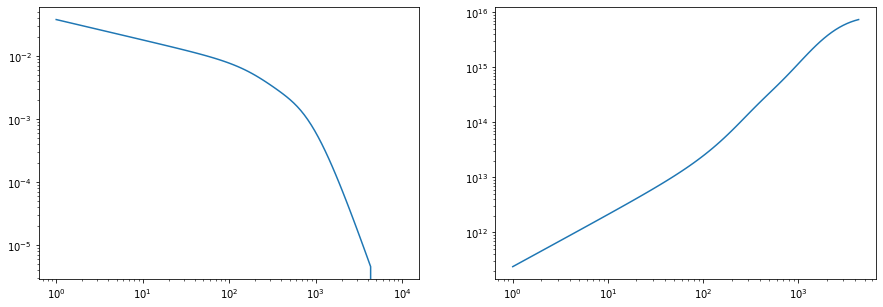

In [6]:
#===== Defines a pure hydro model
cl_model = minot.Cluster(redshift=cl_redshift, M500=cl_M500, silent=True)
cl_model.set_pressure_gas_universal_param('A10MD') # Set to model RM1
cl_model.density_gas_model = {'name':'User','radius':rad_x,'profile':n_x}

plt.figure(1, figsize=(15,5))
ax = plt.subplot(1, 2, 1)
r,n = cl_model.get_density_gas_profile()
plt.loglog(r, n)

ax = plt.subplot(1, 2, 2)
r,m = cl_model.get_hse_mass_profile()
plt.loglog(r, m)

In [7]:
radius = np.logspace(1,4,1000)*u.kpc

def extract_mass_prof(popt, case='sum', deltaB=500):
    M3d_r, M3d_r_err = phys.sigma_rad_to_M3d_Z23(popt[0], radius, cl_model.R500, state='unrelaxed', case=case, ret_err=True)
    X_l = phys.Eturb_over_Etherm(M3d_r - M3d_r_err)
    X_c = phys.Eturb_over_Etherm(M3d_r)
    X_u = phys.Eturb_over_Etherm(M3d_r + M3d_r_err)

    r,p = cl_model.get_pressure_gas_profile(radius)
    cl_model_l = minot.Cluster(redshift=cl_redshift, M500=cl_M500, silent=True)
    cl_model_l.density_gas_model = {'name':'User','radius':rad_x,'profile':n_x}
    cl_model_l.pressure_gas_model = {'name':'User','radius':r,'profile':p*(1+X_l)}
    cl_model_c = minot.Cluster(redshift=cl_redshift, M500=cl_M500, silent=True)
    cl_model_c.density_gas_model = {'name':'User','radius':rad_x,'profile':n_x}
    cl_model_c.pressure_gas_model = {'name':'User','radius':r,'profile':p*(1+X_c)}
    cl_model_u = minot.Cluster(redshift=cl_redshift, M500=cl_M500, silent=True)
    cl_model_u.density_gas_model = {'name':'User','radius':rad_x,'profile':n_x}
    cl_model_u.pressure_gas_model = {'name':'User','radius':r,'profile':p*(1+X_u)}
    
    _, m_l = cl_model_l.get_hse_mass_profile()
    _, m_c = cl_model_c.get_hse_mass_profile()
    _, m_u = cl_model_u.get_hse_mass_profile()

    R500_0, M500_0 = cl_model.get_mdelta_from_profile(deltaB)
    R500_l, M500_l = cl_model_l.get_mdelta_from_profile(deltaB)
    R500_c, M500_c = cl_model_c.get_mdelta_from_profile(deltaB)
    R500_u, M500_u = cl_model_u.get_mdelta_from_profile(deltaB)
    B_c, B_u, B_l = 1-M500_0/M500_c, 1-M500_0/M500_u, 1-M500_0/M500_l
    print('HSE bias: ', B_c, B_c-B_l, B_u-B_c)
        
    return m_l, m_c, m_u

HSE bias:  0.42239745836023723 0.04858448272072735 0.045977244084824065
HSE bias:  0.38532051683457136 0.05019124812704734 0.04801487611118871
HSE bias:  0.381903364229509 0.050240586473916826 0.04815823383387874
HSE bias:  0.39139988395334924 0.04983910381771284 0.04767248956665615
HSE bias:  0.34871270878037885 0.05103622366335814 0.0496835892850781


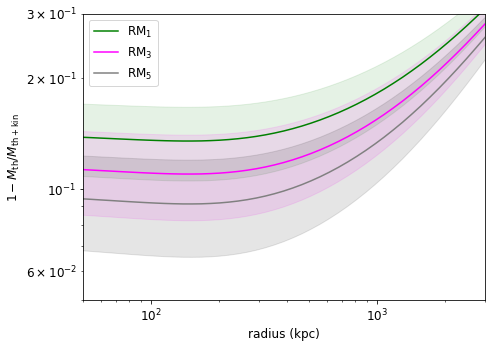

In [8]:
r,m = cl_model.get_hse_mass_profile()

m1_l, m1_c, m1_u = extract_mass_prof(popt1, case='sum')
m2_l, m2_c, m2_u = extract_mass_prof(popt2, case='sum')
m3_l, m3_c, m3_u = extract_mass_prof(popt3, case='sum')
m4_l, m4_c, m4_u = extract_mass_prof(popt4, case='sum')
m5_l, m5_c, m5_u = extract_mass_prof(popt5, case='sum')

plt.rcParams.update({'font.size': 12})
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(0, figsize=(7, 5))
plt.loglog(r,1-m/m1_c, color='green', label='RM$_1$')
plt.fill_between(r.value, 1-m/m1_u, 1-m/m1_l, color='green', alpha=0.1)

#plt.loglog(r,1-m/m2_c, color='orange', label='RM$_2$')
#plt.fill_between(r.value, 1-m/m2_u, 1-m/m2_l, color='orange', alpha=0.1)

plt.loglog(r,1-m/m3_c, color='magenta', label='RM$_3$')
plt.fill_between(r.value, 1-m/m3_u, 1-m/m3_l, color='magenta', alpha=0.1)

#plt.loglog(r,1-m/m4_c, color='blue', label='RM$_4$')
#plt.fill_between(r.value, 1-m/m4_u, 1-m/m4_l, color='blue', alpha=0.1)

plt.loglog(r,1-m/m5_c, color='grey', label='RM$_5$')
plt.fill_between(r.value, 1-m/m5_u, 1-m/m5_l, color='k', alpha=0.1)

plt.xlim(50,3000)
plt.ylim(0.05,0.3)
plt.xlabel('radius (kpc)')
plt.ylabel(r'$1 - M_{\rm th}/M_{\rm th+kin}$')
plt.legend()
plt.savefig(base+'NT_Bhse_sum.pdf')

HSE bias:  0.4219346806582327 0.045836737948412476 0.043298837351610664
HSE bias:  0.37293477038269307 0.04744188825068674 0.04561270511082838
HSE bias:  0.3677134247560163 0.047651138772101365 0.0456740862310564
HSE bias:  0.381937825752511 0.04728570554619327 0.04512655081212902
HSE bias:  0.30759141834117776 0.04825677158394881 0.04771257122065353


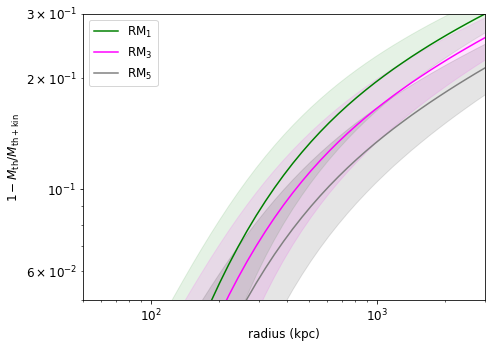

In [9]:
r,m = cl_model.get_hse_mass_profile()

m1_l, m1_c, m1_u = extract_mass_prof(popt1, case='prod')
m2_l, m2_c, m2_u = extract_mass_prof(popt2, case='prod')
m3_l, m3_c, m3_u = extract_mass_prof(popt3, case='prod')
m4_l, m4_c, m4_u = extract_mass_prof(popt4, case='prod')
m5_l, m5_c, m5_u = extract_mass_prof(popt5, case='prod')

plt.rcParams.update({'font.size': 12})
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(0, figsize=(7, 5))
plt.loglog(r,1-m/m1_c, color='green', label='RM$_1$')
plt.fill_between(r.value, 1-m/m1_u, 1-m/m1_l, color='green', alpha=0.1)

#plt.loglog(r,1-m/m2_c, color='orange', label='RM$_2$')
#plt.fill_between(r.value, 1-m/m2_u, 1-m/m2_l, color='orange', alpha=0.1)

plt.loglog(r,1-m/m3_c, color='magenta', label='RM$_3$')
plt.fill_between(r.value, 1-m/m3_u, 1-m/m3_l, color='magenta', alpha=0.1)

#plt.loglog(r,1-m/m4_c, color='blue', label='RM$_4$')
#plt.fill_between(r.value, 1-m/m4_u, 1-m/m4_l, color='blue', alpha=0.1)

plt.loglog(r,1-m/m5_c, color='grey', label='RM$_5$')
plt.fill_between(r.value, 1-m/m5_u, 1-m/m5_l, color='k', alpha=0.1)

plt.xlim(50,3000)
plt.ylim(0.05,0.3)
plt.xlabel('radius (kpc)')
plt.ylabel(r'$1 - M_{\rm th}/M_{\rm th+kin}$')
plt.legend()
plt.savefig(base+'NT_Bhse_prod.pdf')

In [12]:
case = 'sum'
m1_l, m1_c, m1_u = extract_mass_prof(popt1, case=case, deltaB=2500)
m2_l, m2_c, m2_u = extract_mass_prof(popt2, case=case, deltaB=2500)
m3_l, m3_c, m3_u = extract_mass_prof(popt3, case=case, deltaB=2500)
m4_l, m4_c, m4_u = extract_mass_prof(popt4, case=case, deltaB=2500)
m5_l, m5_c, m5_u = extract_mass_prof(popt5, case=case, deltaB=2500)
print('')
m1_l, m1_c, m1_u = extract_mass_prof(popt1, case=case, deltaB=500)
m2_l, m2_c, m2_u = extract_mass_prof(popt2, case=case, deltaB=500)
m3_l, m3_c, m3_u = extract_mass_prof(popt3, case=case, deltaB=500)
m4_l, m4_c, m4_u = extract_mass_prof(popt4, case=case, deltaB=500)
m5_l, m5_c, m5_u = extract_mass_prof(popt5, case=case, deltaB=500)

HSE bias:  0.35055876161846566 0.06443155393990019 0.06438900377163193
HSE bias:  0.30099751081974324 0.06333326365434921 0.06457149498858483
HSE bias:  0.29644861260245436 0.06310211715681846 0.06464052581564583
HSE bias:  0.3089996003360972 0.0635428505792448 0.06463874684755
HSE bias:  0.25438709515763525 0.061083772477441234 0.06385475606045188

HSE bias:  0.42239745836023723 0.04858448272072735 0.045977244084824065
HSE bias:  0.38532051683457136 0.05019124812704734 0.04801487611118871
HSE bias:  0.381903364229509 0.050240586473916826 0.04815823383387874
HSE bias:  0.39139988395334924 0.04983910381771284 0.04767248956665615
HSE bias:  0.34871270878037885 0.05103622366335814 0.0496835892850781
